## Data Curation Part-2


Available products in the dataset
 Available: ['raw_meta_All_Beauty', 'raw_meta_Arts_Crafts_and_Sewing', 'raw_meta_Cell_Phones_and_Accessories', 'raw_meta_Electronics', 'raw_meta_Gift_Cards', 'raw_meta_Handmade_Products', 'raw_meta_Industrial_and_Scientific', 'raw_meta_Musical_Instruments', 'raw_meta_Toys_and_Games']\n"

In [1]:
#Imports
import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [2]:
# Enviroments
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')
os.environ['HUGGINGFACEHUB_API_TOKEN'] = os.getenv('HUGGINGFACEHUB_API_TOKEN')


In [3]:
#Logging to HuggingFace
hf_token = os.environ['HUGGINGFACEHUB_API_TOKEN']
login(hf_token,add_to_git_credential=True)

In [4]:
from items import Item

In [5]:
%matplotlib inline

In [6]:
items = ItemLoader("raw_meta_Electronics").load()

Loading dataset raw_meta_Electronics


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1611/1611 [27:24<00:00,  1.02s/it]


Completed raw_meta_Electronics with 478,755 datapoints in 27.6 mins


In [14]:
print(items[1].prompt)

How much does this cost to the nearest dollar?

NotoCity Compatible with Vivoactive 4 band 22mm Quick Release Silicone Bands/Garmin Darth Vader/First Avenger/Polar Vantage Smartwatch Sport Breathable Strap Replacement for Gear S3 Classic Watchband
☛NotoCity 22mm band is designed for Vivoactive 4 / Samsung Gear S3 Classic / S3 Frontier / Gear Live / Samsung Galaxy Watch 46mm / Huawei Watch GT / Tickwatch Pro / S2 / E2 / Pebble Classic / Time / Time Steel / Pebble 2 (Not Pebble steel) / Other Watches with 22mm lugs.

Price is $10.00


In [6]:
# Scaling up data. I'll take beauty here
dataset_names = ["raw_meta_All_Beauty","raw_meta_Gift_Cards"]

In [7]:
store = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    store.extend(loader.load())

Loading dataset raw_meta_All_Beauty


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:46<00:00,  2.41it/s]

Completed raw_meta_All_Beauty with 6,380 datapoints in 0.9 mins
Loading dataset raw_meta_Gift_Cards



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.14it/s]

Completed raw_meta_Gift_Cards with 350 datapoints in 0.1 mins


In [8]:
print(f"A total of {len(store):,} items")

A total of 6,730 items


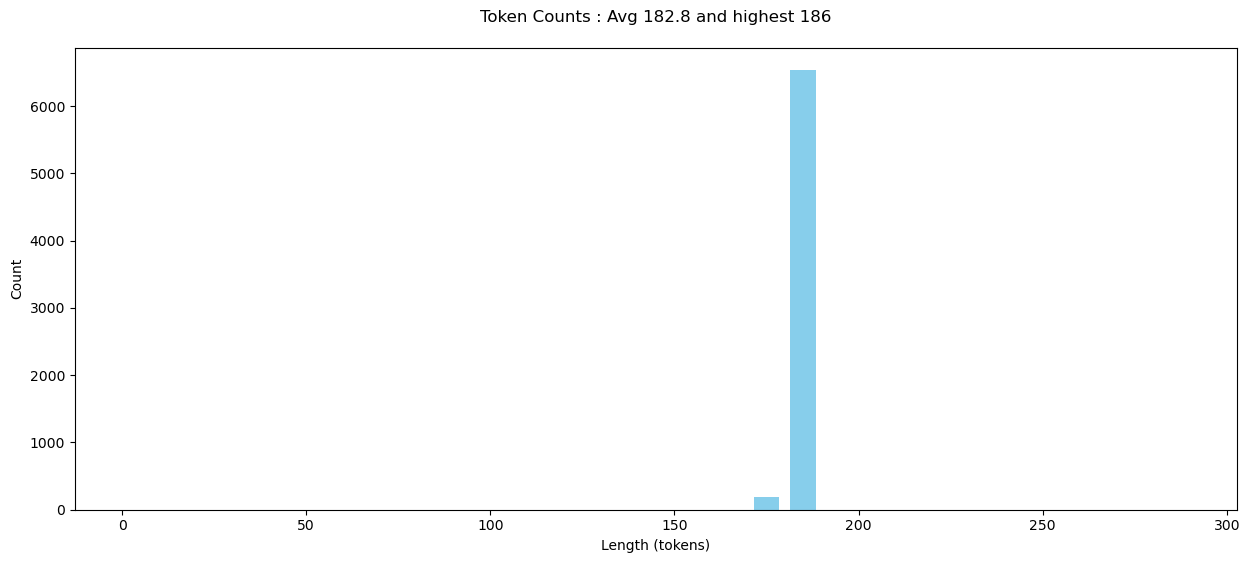

In [9]:
# Plot the distributin og tokens count again
tokens = [item.token_count for item in store]
plt.figure(figsize=(15,6))
plt.title(f"Token Counts : Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0,300,10))
plt.show()

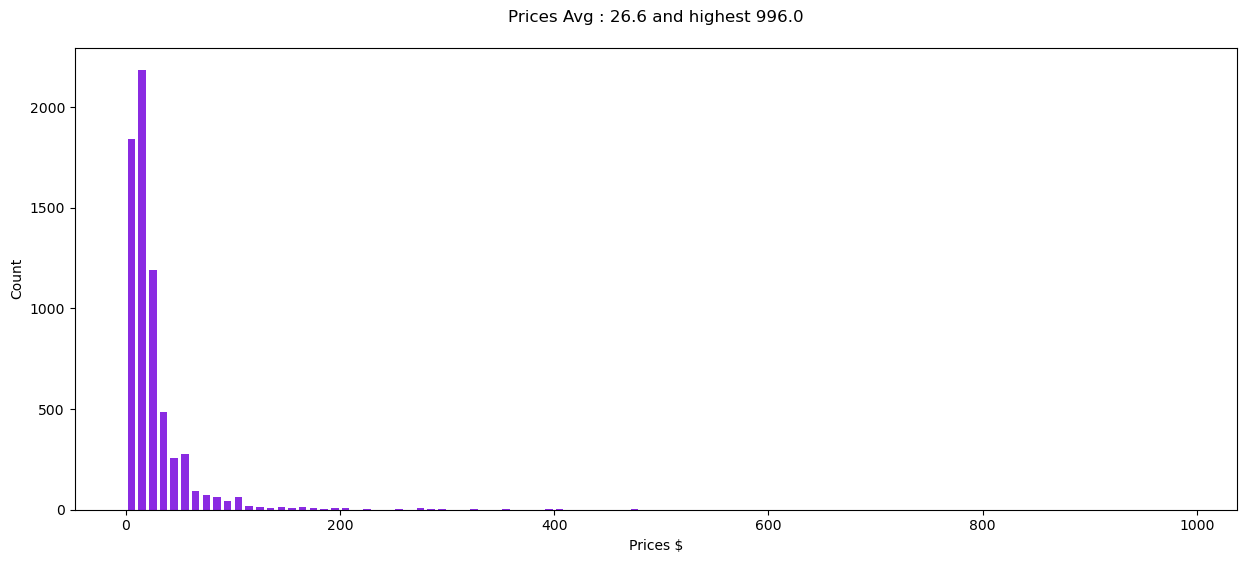

In [11]:
#Plot the distribuiton of prices
prices = [item.price for item in store]
plt.figure(figsize=(15,6))
plt.title(f"Prices Avg : {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel("Prices $")
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0,1000,10))
plt.show()

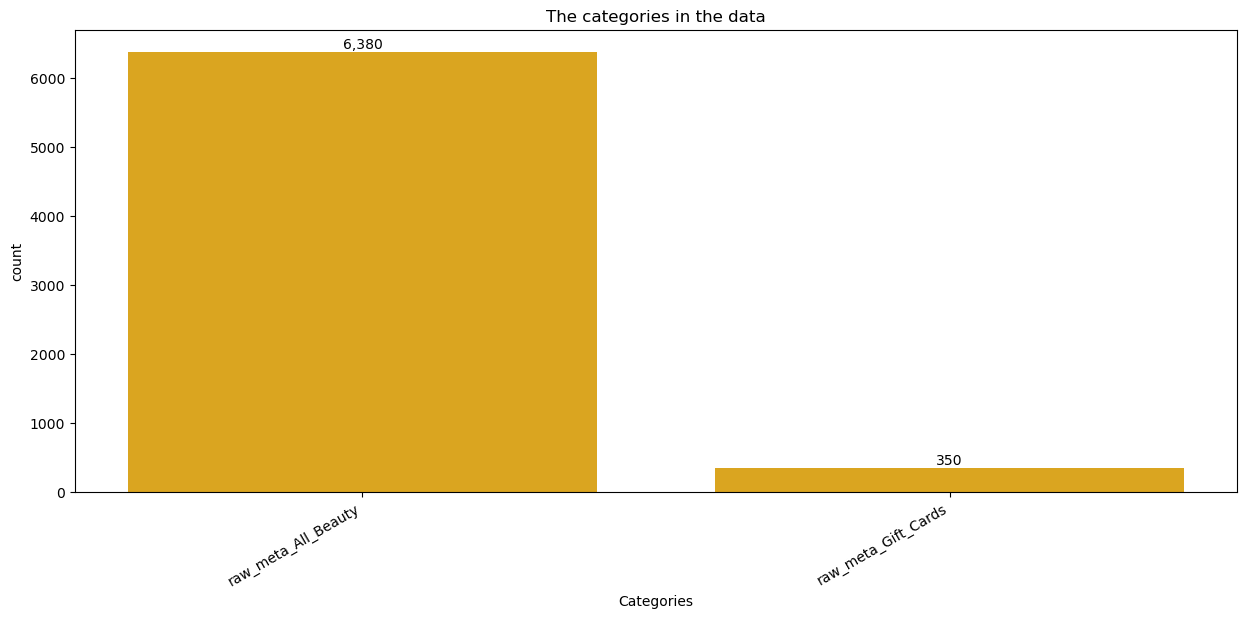

In [15]:
category_counts = Counter()
for item in store:
    category_counts[item.category] += 1

categoreies = category_counts.keys()

counts = [category_counts[category] for category in categoreies]

# barchart for category
plt.figure(figsize=(15,6))
plt.bar(categoreies,counts, color="goldenrod")
plt.title("The categories in the data")
plt.xlabel("Categories")
plt.ylabel("count")
plt.xticks(rotation=30,ha='right')

for i,v in enumerate(counts):
    plt.text(i,v,f"{v:,}", ha='center', va='bottom')

plt.show()

In [17]:
categoreies

dict_keys(['raw_meta_All_Beauty', 'raw_meta_Gift_Cards'])

In [16]:
# I am keeping this data beacuse this is small in size and won't overload my laptop
# and I can walk thought the enitre training. The score maynot be good. But we'll see

I'll balance the prices, but I'm not 

In [18]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in store:
    slots[round(item.price)].append(item)

In [25]:
np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=26:
        sample.extend(slot)
    elif len(slot) <= 990:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='raw_meta_All_Beauty' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 6,730 items in the sample


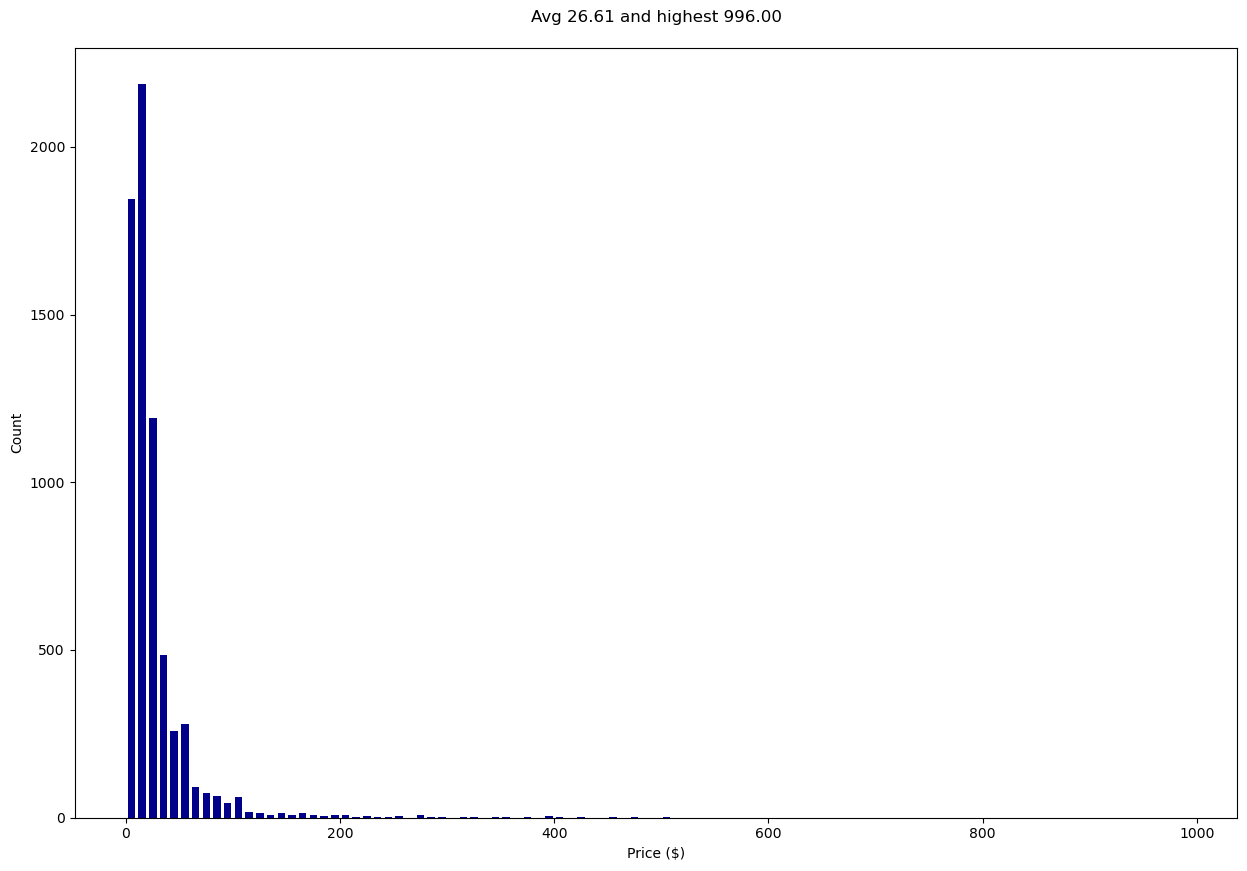

In [26]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

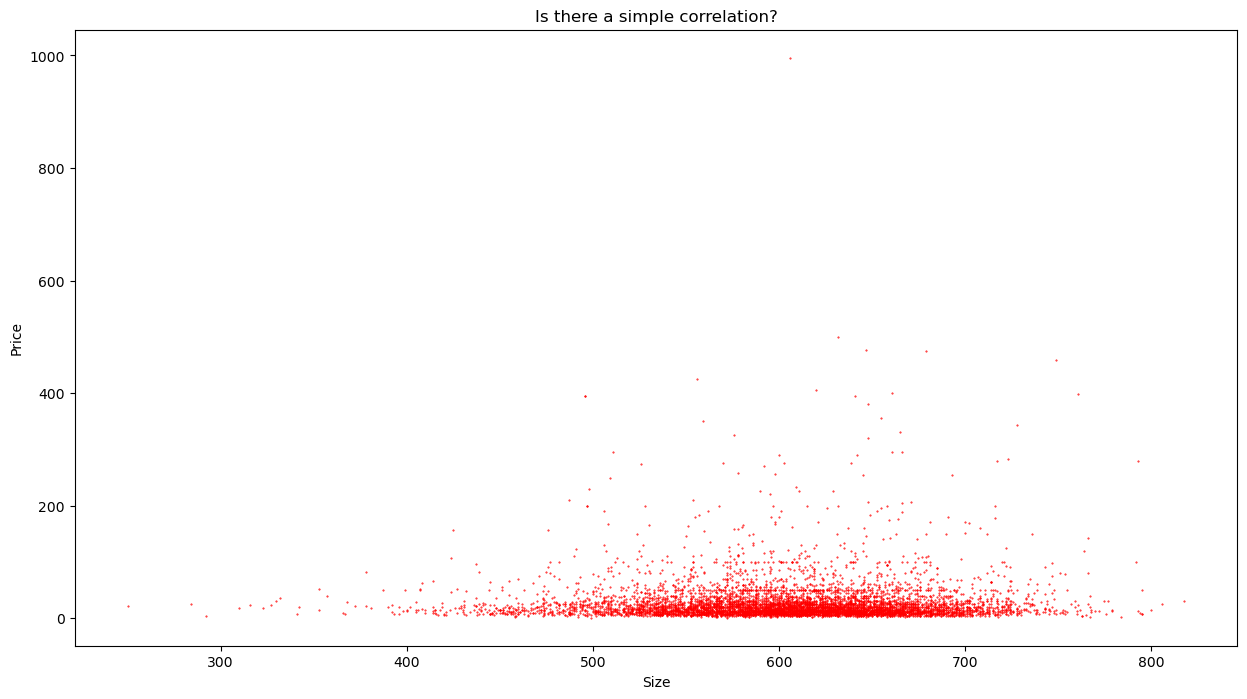

In [27]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [28]:
#6730 samples
# traiin = 5000
# test 1730

SyntaxError: invalid syntax (1467830043.py, line 1)

In [30]:
random.seed(42)
random.shuffle(sample)
train = sample[:5000]
test = sample[5000:6730]
print(f"Training sample : {len(train)}, test sample : {len(test)}")

Training sample : 5000, test sample : 1730


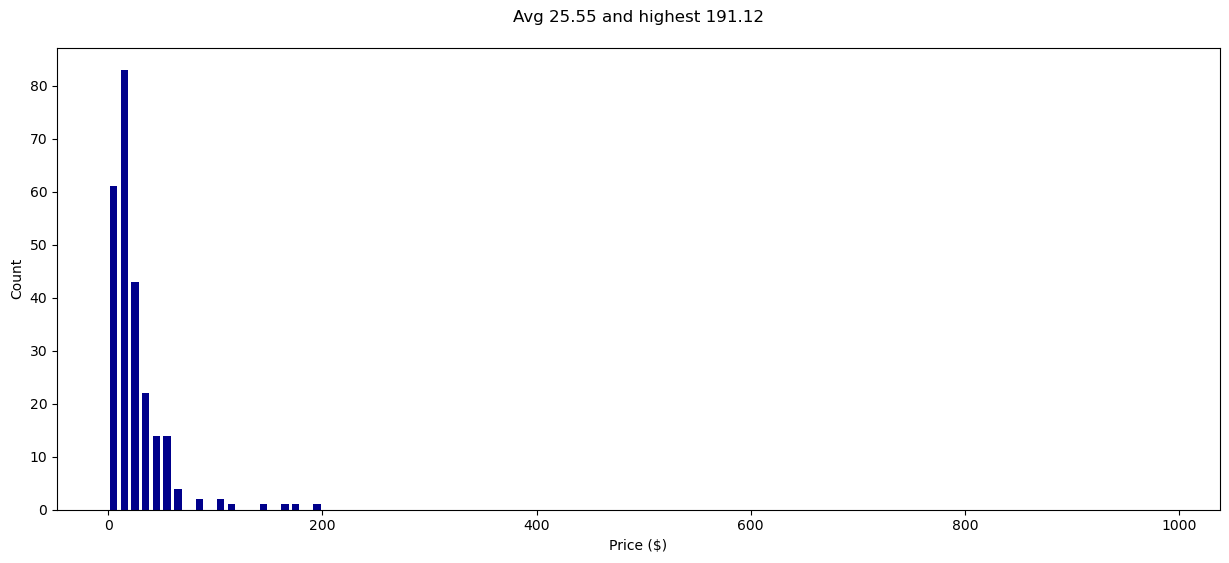

In [32]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in train[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

In [33]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)

In [34]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [36]:
from datasets import DatasetDict

dataset.save_to_disk("pricer-data")


Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1730 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_from_disk

dataset = load_from_disk("my_dataset")
